Episode 0 finished after 19 timesteps, total reward: 19.0
Episode 1 finished after 12 timesteps, total reward: 12.0
Episode 2 finished after 13 timesteps, total reward: 13.0
Episode 3 finished after 17 timesteps, total reward: 17.0
Episode 4 finished after 24 timesteps, total reward: 24.0
Episode 5 finished after 24 timesteps, total reward: 24.0
Episode 6 finished after 16 timesteps, total reward: 16.0
Episode 7 finished after 22 timesteps, total reward: 22.0
Episode 8 finished after 14 timesteps, total reward: 14.0
Episode 9 finished after 11 timesteps, total reward: 11.0
Episode 10 finished after 11 timesteps, total reward: 11.0
Episode 11 finished after 9 timesteps, total reward: 9.0
Episode 12 finished after 13 timesteps, total reward: 13.0
Episode 13 finished after 24 timesteps, total reward: 24.0
Episode 14 finished after 13 timesteps, total reward: 13.0
Episode 15 finished after 15 timesteps, total reward: 15.0
Episode 16 finished after 28 timesteps, total reward: 28.0
Episode 1

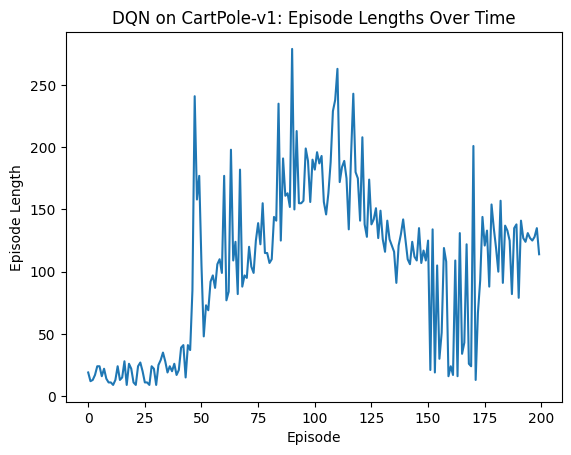

In [4]:
import gym
import math
import random
import numpy as np
np.bool8 = np.bool
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make("CartPole-v1")

# A Transition holds (state, action, next_state, reward)
# Each element:
#   - state: tensor with shape [1, n_observations] (e.g., [1, 4] for CartPole)
#   - action: tensor with shape [1, 1] (e.g., [[0]] or [[1]])
#   - next_state: tensor with shape [1, n_observations] if not terminal, or None
#   - reward: tensor with shape [1] (e.g., [1.0])
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
    
    def push(self, *args):
        """Save a transition."""
        self.memory.append(Transition(*args))
        
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, n_actions)
    
    def forward(self, x):
        # x has shape [batch_size, n_observations]; for a single state, batch_size = 1
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)  # output shape [batch_size, n_actions]

# Hyperparameters
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9        # Starting value for epsilon in epsilon-greedy policy
EPS_END = 0.05         # Minimum epsilon
EPS_DECAY = 200        # Controls decay rate of epsilon
TARGET_UPDATE = 10     # How often to update the target network (in episodes)
LR = 1e-3              # Learning rate for optimizer
NUM_EPISODES = 200     # Total number of episodes to train
MEMORY_CAPACITY = 10000


n_observations = env.observation_space.shape[0]  
n_actions = env.action_space.n                   

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()  

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(MEMORY_CAPACITY)

steps_done = 0  

def select_action(state):
    """
    Select an action for the given state using epsilon-greedy policy.
    - state: tensor of shape [1, n_observations]
    Returns:
      action: tensor of shape [1, 1]
    """
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1.0 * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

def compute_loss(batch):
    """
    Compute the Mean Squared Error (MSE) loss for a batch of transitions.
    Each element of the batch is:
      - state: [1, n_observations] (e.g., [1, 4])
      - action: [1, 1] (e.g., [[0]] or [[1]])
      - next_state: [1, n_observations] or None (if terminal)
      - reward: [1]
    This function loops over each transition, uses an if/else to check if next_state is terminal,
    and calculates the Q-value target accordingly.
    """
    losses = []  
    for state, action, next_state, reward in zip(batch.state, batch.action, batch.next_state, batch.reward):
        q_pred = policy_net(state).gather(1, action)
        if next_state is None:
            q_target = reward 
        else:
            with torch.no_grad():
                q_next_max = target_net(next_state).max(1)[0]
            q_target = reward + GAMMA * q_next_max
        loss_i = (q_pred.squeeze() - q_target.squeeze()) ** 2
        losses.append(loss_i)
    loss = sum(losses) / len(losses)
    return loss

def optimize_model():
    """Sample a batch of transitions from memory and perform one optimization step."""
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    loss = compute_loss(batch)
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        if param.grad is not None:
            param.grad.data.clamp_(-1, 1)
    optimizer.step()

episode_durations = []

for i_episode in range(NUM_EPISODES):
    state, _ = env.reset()
    state = torch.tensor([state], device=device, dtype=torch.float32)
    total_reward = 0
    for t in count():
        action = select_action(state) 
        observation, reward, terminated, truncated, _ = env.step(action.item())
        total_reward += reward
        reward_tensor = torch.tensor([reward], device=device, dtype=torch.float32)
        
        if terminated or truncated:
            next_state = None  
        else:
            next_state = torch.tensor([observation], device=device, dtype=torch.float32)
        memory.push(state, action, next_state, reward_tensor)
        if next_state is not None:
            state = next_state
        else:
            state = torch.zeros((1, n_observations), device=device, dtype=torch.float32)
        optimize_model()
        if terminated or truncated:
            episode_durations.append(t + 1)
            print(f"Episode {i_episode} finished after {t+1} timesteps, total reward: {total_reward}")
            break
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print("Training complete")
env.close()

plt.figure()
plt.plot(episode_durations)
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.title("DQN on CartPole-v1: Episode Lengths Over Time")
plt.show()
